In [1]:
#|default_exp sgd

### Accelerated SGD

In [2]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.activations import *
from miniai.init import *

In [3]:

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

### SGD

In [7]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 -self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [8]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.773,0.638,0,train
0.826,0.473,0,eval
0.847,0.421,1,train
0.848,0.415,1,eval
0.866,0.368,2,train
0.851,0.400,2,eval


/home/chung/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


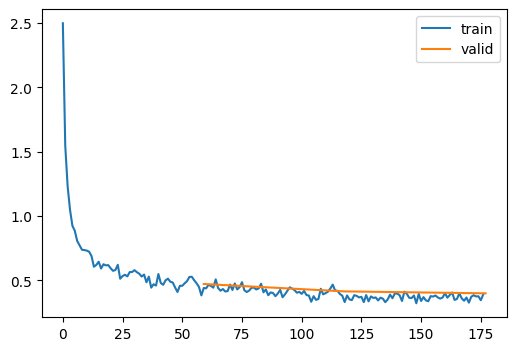

In [9]:
learn.fit(3)

Consider the difference between weight decay and L2 regularization:
```
weight -= lr*wd*weight
```
...vs...
```
weight.grad += wd*weight
```

### Momentum

In [10]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

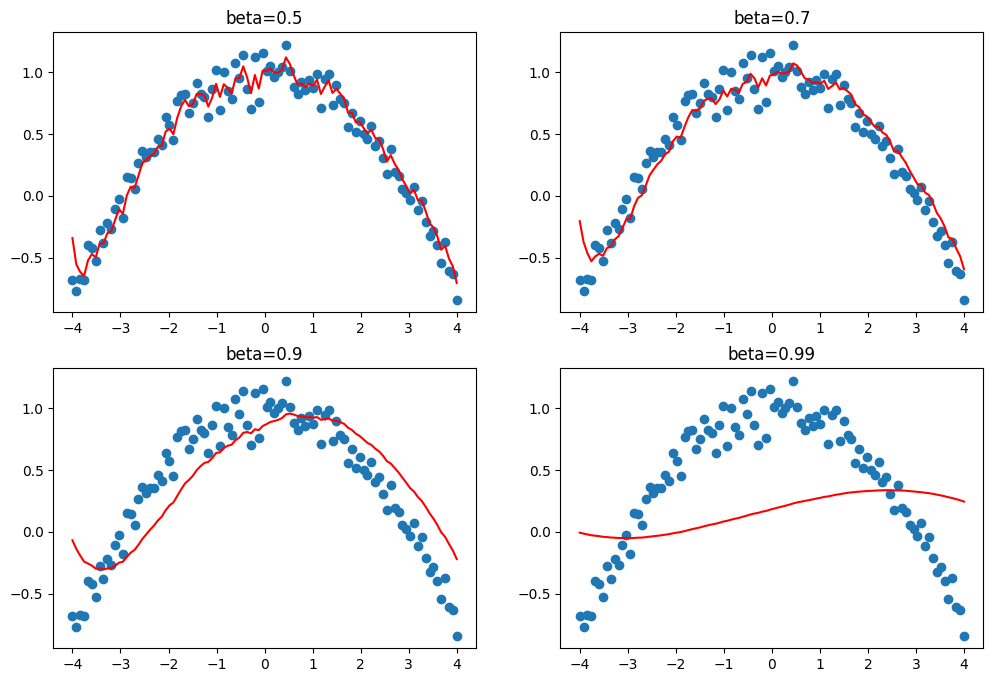

In [11]:
_, axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0, []
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [12]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd= wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [13]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.785,0.597,0,train
0.844,0.418,0,eval
0.868,0.357,1,train
0.857,0.375,1,eval
0.885,0.314,2,train
0.864,0.366,2,eval


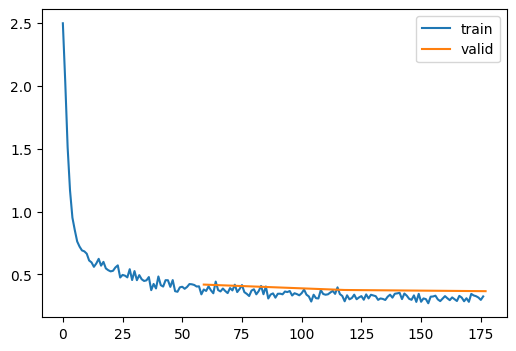

In [14]:
learn.fit(3)

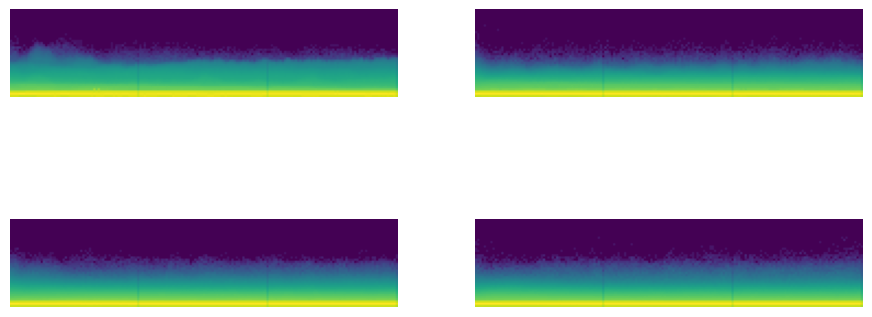

In [15]:
astats.color_dim()

In [16]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        upd = p.grad/(p.sqr_avg.sqrt() + self.eps)
        p -= self.lr * upd

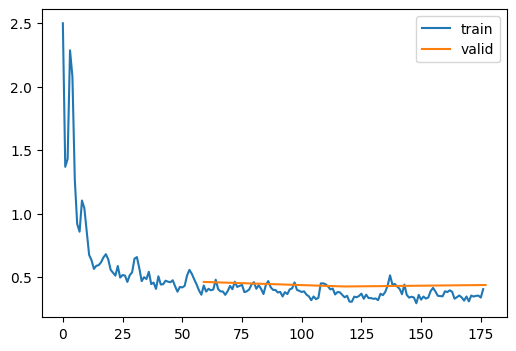

In [17]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

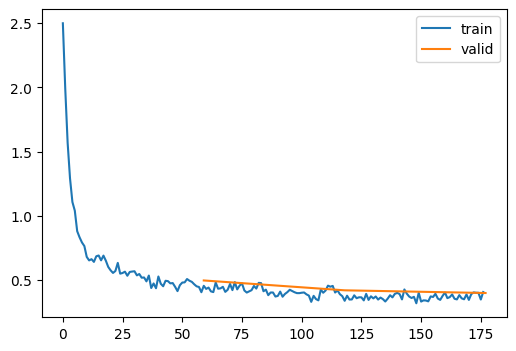

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

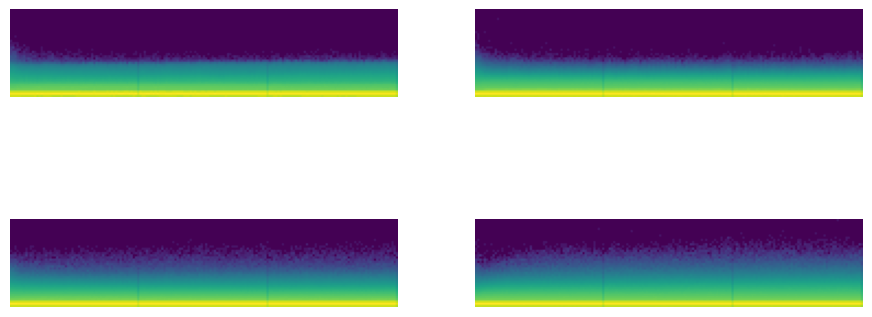

In [19]:
astats.color_dim()

### ADAM

In [20]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

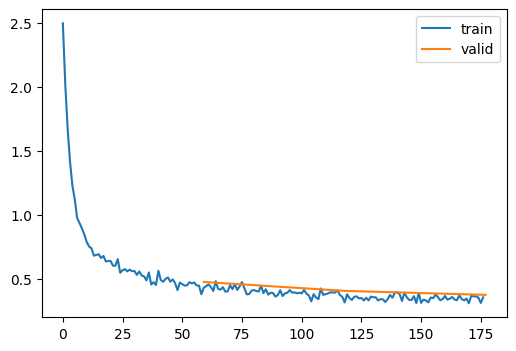

In [21]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

### Schedulers

We've already seen how we can easily write custom LR-adjusting callback or Learner, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [24]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [25]:
from fastcore.basics import Self as X

In [26]:
' '.join(filter(X[0].isupper() and X[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR _check_verbose_deprecated_warning _enable_get_lr_call bisect_right inf math partial types warnings weakref wraps'

In [27]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [28]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'OptimizerPostHook OptimizerPreHook add_param_group defaults load_state_dict param_groups profile_hook_step register_load_state_dict_post_hook register_load_state_dict_pre_hook register_state_dict_post_hook register_state_dict_pre_hook register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [29]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [30]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [32]:
st

{'momentum_buffer': None}

In [33]:
len(opt.param_groups)

1

In [34]:
pg = opt.param_groups[0]

In [35]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [36]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [37]:
sched.base_lrs

[0.006]

In [38]:
sched.get_last_lr()

[0.006]

In [39]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

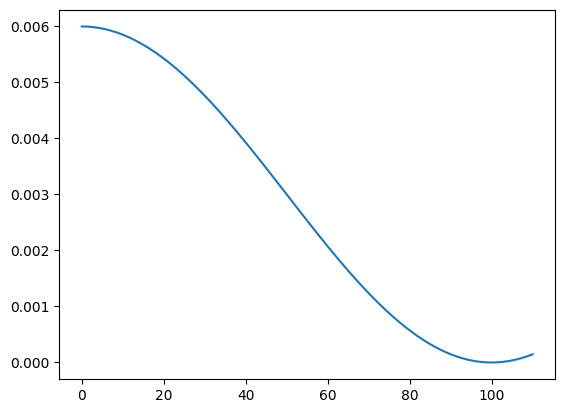

In [40]:
sched_lrs(sched, 110)

### Scheduler callbacks

In [50]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def step(self, learn):
        if learn.training: self.schedo.step()

In [51]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self.step(learn)

In [43]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn
    def after_fit(self, learn): self.learn = None

In [44]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [45]:
def _lr(cb): return cb.pg['lr']

In [46]:
len(dls.train)

59

In [47]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.809,0.518,0,train
0.849,0.413,0,eval
0.881,0.325,1,train
0.875,0.330,1,eval
0.898,0.278,2,train
0.883,0.318,2,eval


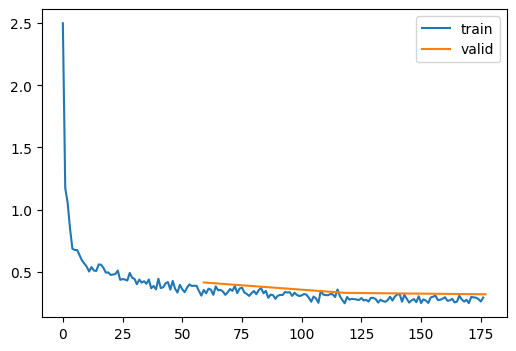

In [48]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

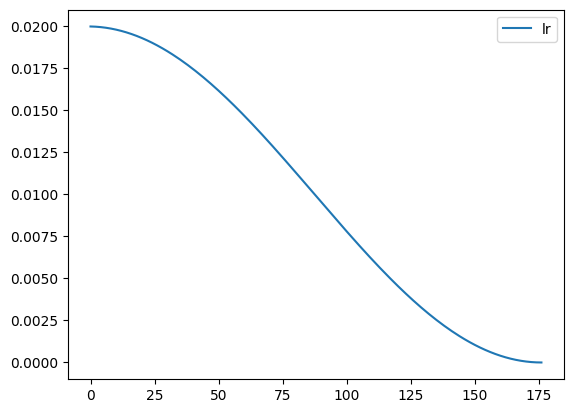

In [49]:
rec.plot()

In [52]:
#|exort
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self.step(learn)

accuracy,loss,epoch,train
0.809,0.518,0,train
0.850,0.401,0,eval
0.881,0.325,1,train
0.869,0.348,1,eval
0.900,0.272,2,train
0.884,0.311,2,eval


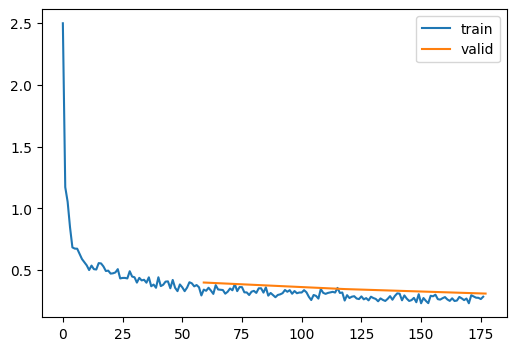

In [53]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched), rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

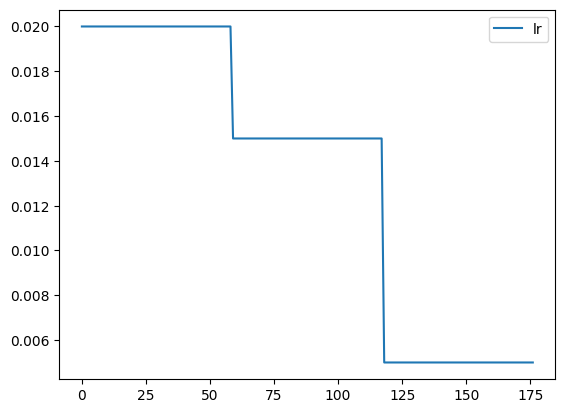

In [54]:
rec.plot()

### 1cycle training

paper by Leslie Smith.

In [55]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

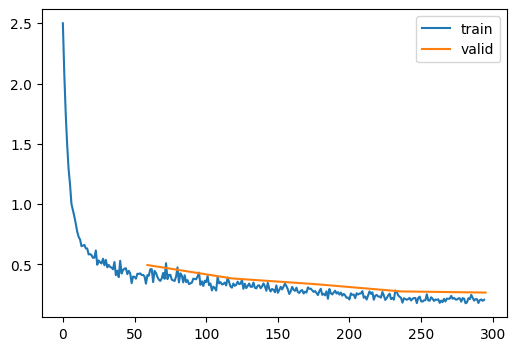

In [57]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

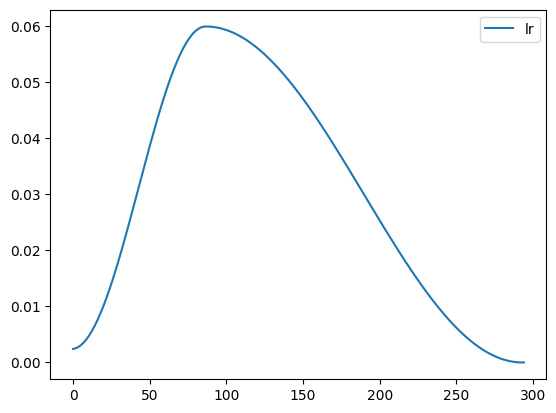

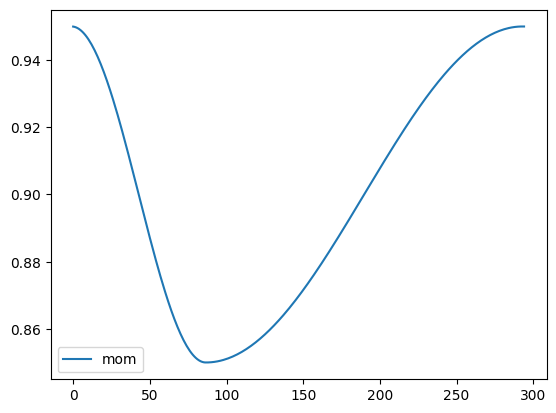

In [58]:
rec.plot()